In [2]:

import torch.optim as optim

import numpy as np
import torch 
import torch.nn.functional as F
import glob
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode
from torch import nn

from PIL import Image
import matplotlib.pyplot as plt
from torch.autograd import Function

import torch.optim as optim
from torch.optim import lr_scheduler

In [3]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Text(0.5, 1.0, ' LR Scheduler')

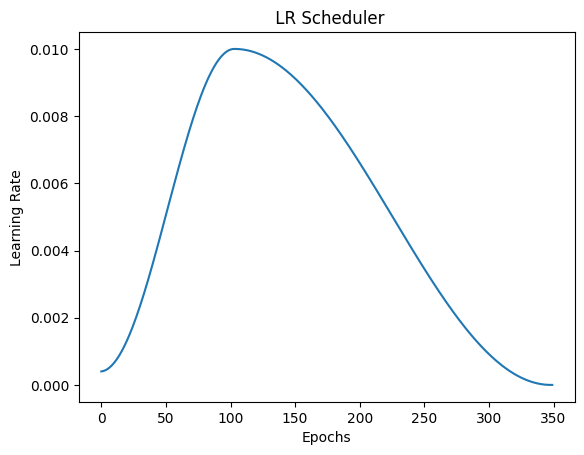

In [4]:
model = nn.Linear(2, 1)
num_epochs = 350
# optimizer = optim.Adam(model.parameters(), lr=0.001)
config = {
	"lr" : 0.1,
	"momentum" : 0.9,
	"weight_decay" : 0.0001,
}
# optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config["weight_decay"])
# scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=350, T_mult=2, eta_max=0.04,  T_up=10, gamma=0.5)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
#scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=200, T_mult=2, eta_max=0.006,  T_up=10, gamma=0.002)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,total_steps=350,steps_per_epoch=int(40000/64), epochs=350)

lrs  = []
for i in range(num_epochs):
	scheduler.step()
	lrs.append(optimizer.param_groups[0]["lr"])  

plt.plot(lrs)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title(" LR Scheduler")